
# Slim simulations



In [1]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

np.random.seed(7)

Import variables global to the entire analysis:

In [2]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [3]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Plotting setup:

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

Ignore warnings:

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code

In [6]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Compute demographies

In [103]:
years2gen = dict()
for x in range(0, 200000):
    years2gen[x] = int(6896 - x / 29)

def bottleneck_N(t):
    return int(round(t / (1/1000 - (1-t)/20000)))

bottle_start, bottle_end, bottle_N = 30000, 100000, 2000 * smallest_x_auto_fraction

t = Series([1, 2/3, 1/3])
demog = DataFrame(dict(bottle_N=t.map(bottleneck_N), 
                               bottle_time=t*(bottle_end - bottle_start)))
demog['bottle_start'] = round(bottle_start + (bottle_end - bottle_start - demog.bottle_time) / 2).astype(int)
demog['bottle_end'] = round(bottle_end - (bottle_end - bottle_start - demog.bottle_time) / 2).astype(int)

demog

,bottle_N,bottle_time,bottle_start,bottle_end
0,1000,70000.000000,30000,100000
1,678,46666.666667,41667,88333
2,345,23333.333333,53333,76667


Print for loading into `workflow.py`:

In [105]:
list(zip(list(years2gen[x] for x in demog.bottle_start),
list(years2gen[x] for x in demog.bottle_end),
demog.bottle_N))

[(5861, 3447, 1000), (5459, 3850, 678), (5056, 4252, 345)]

In [110]:
[years2gen[x] for x in [20000, 50000, 110000]]

[6206, 5171, 3102]

## Load data for sweeps called on simulations

In [81]:
prop_swept_data = pd.read_hdf(str(ag.steps_dir / 'slim' / 'slim_summary.hdf'))
prop_swept_data['prop_swept'] = prop_swept_data.nr_swept / prop_swept_data.total

records = list()
for sweep_type, *rest in prop_swept_data.simulation.str.split('_'):
    records.append([sweep_type] + list(map(int, rest)))


df = pd.DataFrame.from_records(records, 
                      columns=['sweep_type', 'N', 'bottle_start', 'bottle_end', 'bottle_width', 'sweep_start'], 
                              )
df['bottle_width'] = df.bottle_end - df.bottle_start
prop_swept_data = prop_swept_data.merge(df, left_index=True, right_index=True)
prop_swept_data.head()

,start,end,nr_swept,total,simulation,replication,selection_coef,prop_swept,sweep_type,N,bottle_start,bottle_end,bottle_width,sweep_start
0,0,100000,0.0,140,complete_20000_3448_5861_20000_5500,7,0.2,0.0,complete,20000,3448,5861,2413,5500
0,0,100000,0.0,140,complete_20000_3448_5861_20000_5500,2,0.2,0.0,complete,20000,3448,5861,2413,5500
0,0,100000,0.0,140,complete_20000_3448_5861_20000_5500,3,0.2,0.0,complete,20000,3448,5861,2413,5500
0,0,100000,0.0,140,complete_20000_3448_5861_20000_5500,9,0.2,0.0,complete,20000,3448,5861,2413,5500
0,0,100000,0.0,140,complete_20000_3448_5861_20000_5500,6,0.2,0.0,complete,20000,3448,5861,2413,5500


In [10]:
# prop_swept_data['simulation'] = pd.Categorical(prop_swept_data.simulation, 
#                                                ordered=True,
#                                                categories=['bottle', 
#                                                            'partial_before_bottle', 
#                                                            'partial_in_bottle', 
#                                                            'partial_after_bottle', 
#                                                            'complete_before_bottle', 
#                                                            'complete_in_bottle', 
#                                                            'complete_after_bottle',
#                                                            'complete_after_no_bottle'
#                                                           ])

In [11]:
# prop_swept_data = prop_swept_data.loc[prop_swept_data.simulation.str.startswith('complete')]
# prop_swept_data.head()                                      
                                      

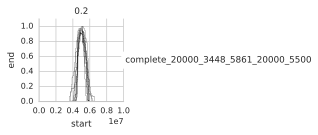

In [42]:
def facet_plot(start, end, prop_swept, **kwargs):
    x = [j for i in zip(start, end) for j in i]
    y = [j for i in zip(prop_swept, prop_swept) for j in i]      
    plt.plot(x, y, color='black', linewidth=0.2)
    plt.ylim((0, 1.1))
#    plt.fill_between(x, 0, y, color='gray', alpha=0.05)


with sns.axes_style('whitegrid'):
#     g = sns.FacetGrid(prop_swept_data, col='simulation', row='selection_coef', 
    g = sns.FacetGrid(prop_swept_data, col='selection_coef', row='simulation', 
                      hue='replication', sharex=True, sharey=True, margin_titles=True,
                     size=2)
    g.map(facet_plot, 'start', 'end', 'prop_swept')

    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for ax in g.axes.flat:
        plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles



In [15]:
# (prop_swept_data
#  .loc[lambda df: (df.simulation == 'complete_20000_3448_5861_20000_6000') & (df.selection_coef == 0.01)]
#  .head()
# )



/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/complete/20000/3448/5861/20000/5500/20/complete_20000_3448_5861_20000_5500_20_0.hdf


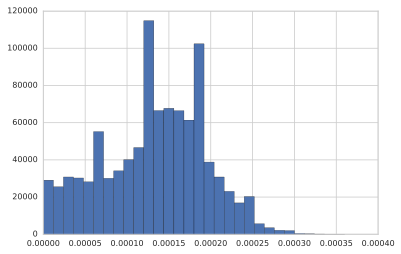

In [43]:
s = 'complete_20000_3448_5861_20000_5500_{}'.format(20)
f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
print(f_name_tmpl.format(0))
df = pd.read_hdf(f_name_tmpl.format(0))

# s = 'complete_20000_3448_5861_2000_5171_{}'.format(1)
# f_name = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_0.hdf'.format(s)
df = pd.read_hdf(f_name_tmpl.format(0))
plt.hist(df.dist, bins=30) ;






In [44]:
# s = 'complete_20000_3448_5861_2000_5171_{}'.format(1)
# f_name_tmpl = '/home/kmt/simons/faststorage/people/kmt/steps/slim/simulations/' + s.replace('_', '/') + '/{}_{{}}.hdf'.format(s)
# df = pd.read_hdf(f_name_tmpl.format(0))



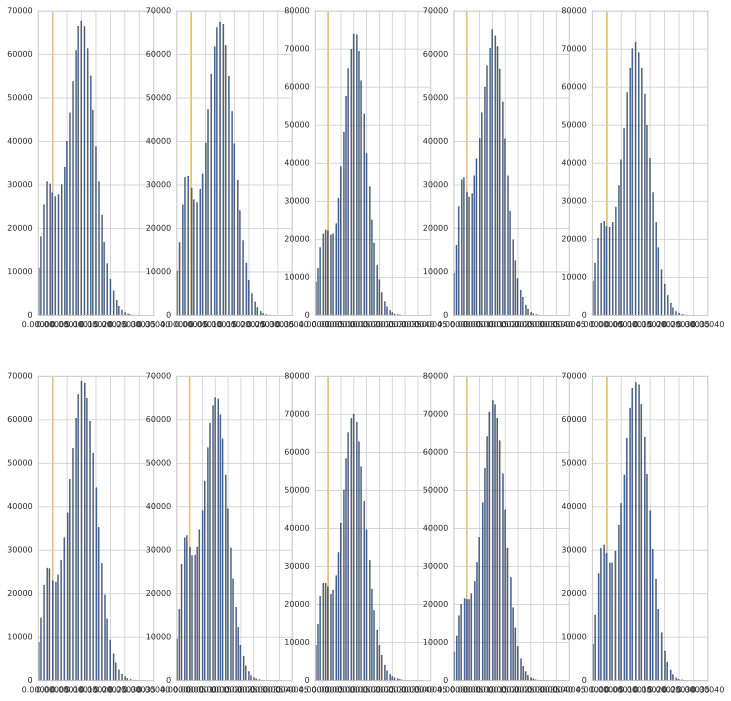

In [45]:
plt.figure(figsize=(12,12))
for i in range(10):
    plt.subplot(2, 5, i+1)
    df = pd.read_hdf(f_name_tmpl.format(i))
    plt.hist(df.dist, bins=100)
    plt.axvline(5e-5, color='orange', zorder=0)

7.77761414141414e-05
8.214795959595959e-05


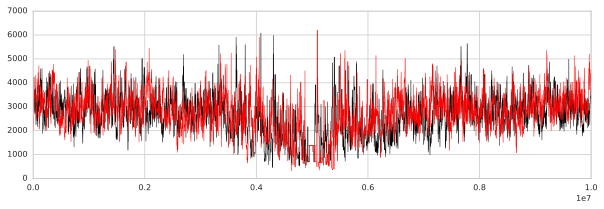

In [46]:
import pyslim, msprime, random
seed = 7
mutation_rate = 1.25e-8
sample_size = 100

trees = pyslim.load(f_name_tmpl.format(0).replace('.hdf', '.trees'))

# Overlay neutral mutations and make bit arrays for each SNP:
sample_ids = sorted(random.sample(list(trees.samples()), sample_size))

trees_sample = trees.simplify(samples=sample_ids, filter_zero_mutation_sites=True, filter_individuals=True)
mutated_trees = msprime.mutate(trees_sample, rate=mutation_rate, random_seed=seed)
# mutated.dump("./sweep_overlaid.trees") 
print(mutated_trees.pairwise_diversity() / mutated_trees.sequence_length)


ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos
plt.figure(figsize=(10,3))
plt.plot(height_for_pos, linewidth=0.5, color='black') ;


trees = pyslim.load(f_name_tmpl.format(1).replace('.hdf', '.trees'))

# Overlay neutral mutations and make bit arrays for each SNP:
sample_ids = sorted(random.sample(list(trees.samples()), sample_size))

trees_sample = trees.simplify(samples=sample_ids, filter_zero_mutation_sites=True, filter_individuals=True)
mutated_trees = msprime.mutate(trees_sample, rate=mutation_rate, random_seed=seed)
# mutated.dump("./sweep_overlaid.trees") 
print(mutated_trees.pairwise_diversity() / mutated_trees.sequence_length)


ts = mutated_trees
# Measure the tree height at each base position
height_for_pos = np.zeros(int(ts.sequence_length))
for tree in ts.trees():
    mean_height = np.mean([tree.time(root) for root in tree.roots])
    left, right = map(int, tree.interval)
    height_for_pos[left: right] = mean_height
height_for_pos

plt.plot(height_for_pos, linewidth=0.5, color='red') ;





